In [3]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from helpers import *

In [4]:
from car_data import bmws, priuses
all_car_data = []
for bmw in bmws:
    all_car_data.append((bmw.mileage,bmw.price,1))
for prius in priuses:
    all_car_data.append((prius.mileage,prius.price,0))

In [5]:
def bmw_finder(mileage,price):
    if price > 25000:
        return 1
    else:
        return 0

In [6]:
def test_classifier(classifier, data):
    trues = 0
    falses = 0
    for mileage, price, is_bmw in data:
        if classifier(mileage, price) == is_bmw: #1
            trues += 1
        else:
            falses += 1 #1
    return trues / (trues + falses)

In [7]:
test_classifier(bmw_finder, all_car_data)

0.59

In [8]:
def test_classifier(classifier, data, verbose=False): #1
    true_positives = 0 #2
    true_negatives = 0
    false_positives = 0
    false_negatives = 0
    for mileage, price, is_bmw in data:
        predicted = classifier(mileage,price)
        if predicted and is_bmw: #3
            true_positives += 1
        elif predicted:
            false_positives += 1
        elif is_bmw:
            false_negatives += 1
        else:
            true_negatives += 1
            
    if verbose:        
        print("true positives %f" % true_positives) #4
        print("true negatives %f" % true_negatives)
        print("false positives %f" % false_positives)
        print("false negatives %f" % false_negatives)
            
    return (true_positives + true_negatives) / len(data) #5

In [9]:
test_classifier(bmw_finder, all_car_data, verbose=True)

true positives 18.000000
true negatives 100.000000
false positives 0.000000
false negatives 82.000000


0.59

In [10]:
def plot_data(ds):
    plt.scatter([d[0] for d in ds if d[2]==0],[d[1] for d in ds if d[2]==0],c='C1')
    plt.scatter([d[0] for d in ds if d[2]==1],[d[1] for d in ds if d[2]==1],c='C0',marker='x')
    plt.ylabel("Price ($)",fontsize=16)
    plt.xlabel("Odometer (mi)",fontsize=16)

def plot_function(f,xmin,xmax,**kwargs):
    ts = np.linspace(xmin,xmax,1000)
    plt.plot(ts,[f(t) for t in ts],**kwargs)

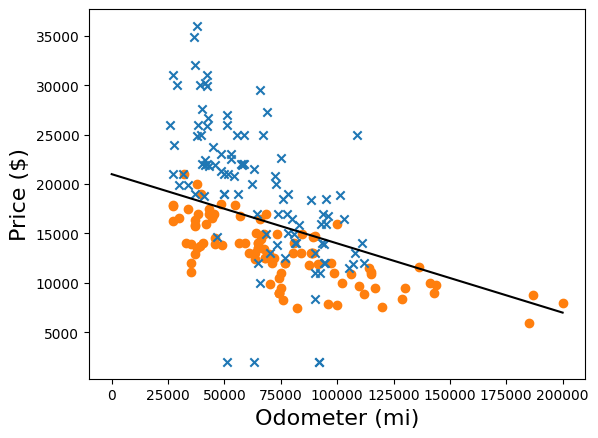

In [11]:
plot_data(all_car_data)
plot_function(lambda x: 21000 - 0.07 * x, 0, 200000, c='black')

In [12]:
def decision_boundary_classify(mileage,price):
    if price > 21000 - 0.07 * mileage:
        return 1
    else:
        return 0

In [13]:
test_classifier(decision_boundary_classify, all_car_data)

0.805

In [18]:
def make_scale(data):
    min_val = min(data) #1
    max_val = max(data)
    def scale(x): #2
        return (x-min_val) / (max_val - min_val)
    def unscale(y): #3
        return y * (max_val - min_val) + min_val
    return scale, unscale #4

price_scale, price_unscale = make_scale([x[1] for x in all_car_data]) #5
mileage_scale, mileage_unscale = make_scale([x[0] for x in all_car_data])

In [20]:
scaled_car_data = [(mileage_scale(mileage), price_scale(price), is_bmw) 
                    for mileage,price,is_bmw in all_car_data]

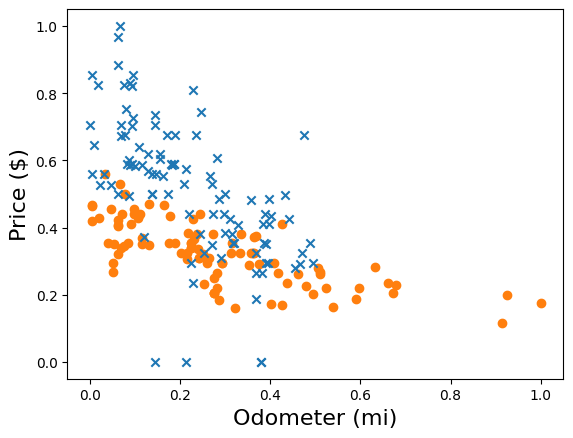

In [21]:
plot_data(scaled_car_data)

### 15.3.3　sigmoid函数

In [23]:
from math import exp, log
def sigmoid(x):
    return 1/(1+exp(-x))

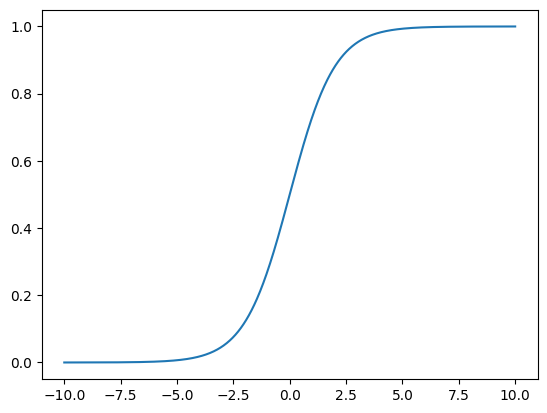

In [16]:
plot_function(sigmoid, -10, 10)

In [17]:
def make_logistic(a, b, c):
    def l(x, p):
        return sigmoid(a*x + b*p -c)
    return l

In [22]:
def simple_logistic_cost(a, b, c):
    l = make_logistic(a, b, c)
    errors = [abs(isbmw - l(x,p)) for x, p, isbmw in scaled_car_data]
    return sum(errors)

In [24]:
def point_cost(l, x, p, isbmw):
    wrong = 1 - isbmw
    return -log(abs(wrong - l(x,p)))
def logistic_cost(a, b, c):
    l = make_logistic(a, b, c)
    errors = [point_cost(l, x, p, isbmw) for x, p, isbmw in scaled_car_data]
    return sum(errors)

**Mini-project:** What does the graph of $k(x,y) = \sigma(x^2 + y^2 - 1)$ look like? What does the decision boundary look like, meaning the set of points where $k(x,y) = 0.5$?

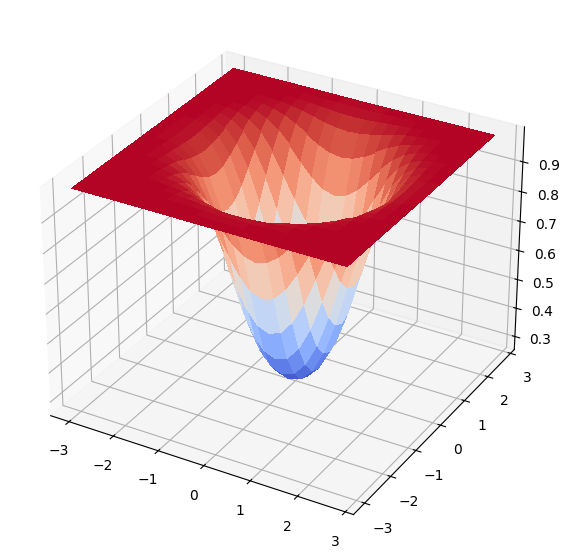

In [25]:
def k(x, y):
    return sigmoid(x**2 + y**2 -1)

plot_scalar_field(k, -3, 3, -3, 3)

### 15.5.1　三维中的梯度下降法

In [26]:
from math import sqrt
def length(v):
    return sqrt(sum([vi*vi for vi in v]))

def secant_slope(f,xmin,xmax):
    return (f(xmax) - f(xmin)) / (xmax - xmin)

def approx_derivative(f,x,dx=1e-6):
    return secant_slope(f,x-dx,x+dx)

In [27]:
def approx_gradient(f,x0,y0,dx=1e-6):
    partial_x = approx_derivative(lambda x:f(x,y0),x0,dx=dx)
    partial_y = approx_derivative(lambda y:f(x0,y),y0,dx=dx)
    return (partial_x,partial_y)

In [28]:
def approx_gradient3(f,x0,y0,z0,dx=1e-6):
    partial_x = approx_derivative(lambda x:f(x,y0,z0),x0,dx=dx)
    partial_y = approx_derivative(lambda y:f(x0,y,z0),y0,dx=dx)
    partial_z = approx_derivative(lambda z:f(x0,y0,z),z0,dx=dx)
    return (partial_x,partial_y,partial_z)

In [29]:
def gradient_descent3(f,xstart,ystart,zstart,
                      tolerance=1e-6,max_steps=1000):
    x = xstart
    y = ystart
    z = zstart
    grad = approx_gradient3(f,x,y,z)
    steps = 0
    while length(grad) > tolerance and steps < max_steps:
        x -= 0.01 * grad[0]
        y -= 0.01 * grad[1]
        z -= 0.01 * grad[2]
        grad = approx_gradient3(f,x,y,z)
        steps += 1
    return x,y,z

In [30]:
gradient_descent3(logistic_cost, 1, 1, 1, max_steps=100)

(0.21114493148496014, 5.045439728207488, 2.1260122566471376)

In [31]:
gradient_descent3(logistic_cost,1,1,1,max_steps=8000)

(3.7167003088210118, 11.422062406779267, 5.596878365032182)

In [32]:
def best_logistic_classifier(x,p):
    l = make_logistic(3.7167003153580045, 11.422062409195114, 5.596878367305919)
    if l(x,p) > 0.5:
        return 1
    else:
        return 0

In [33]:
test_classifier(best_logistic_classifier, scaled_car_data)

0.8